# Лабораторная работа №3 "Регрессионная модель изменения цен на дома в Бостоне"
### Выполнила студентка группы БВТ2101 Пьянова Анна Олеговна

### Цель работы:
Реализовать предсказание медианной цены на дома в пригороде Бостона в середине 1970-х по таким данным, как уровень преступности, ставка местного имущественного налога и т.д.

Данный набор содержит относительно немного образцов данных: всего 506, разбитых на 404 обучающих и 102 контрольных образца. И каждый признак во входных данных (например, уровень преступности) имеет свой масштаб. Например, некоторые признаки являются пропорциями и имеют значения между 0 и 1, другие — между 1 и 12 и т. д. Не путайте регрессию с алгоритмом логистической регрессии. Как ни странно, логистическая регрессия не является регрессионным алгоритмом — это алгоритм классификации.
### Задачи:
- Ознакомиться с задачей регрессии
- Изучить отличие задачи регрессии от задачи классификации
- Создать модель
- Настроить параметры обучения
- Обучить и оценить модели
- Ознакомиться с перекрестной проверкой

### Выполнение работы

Импорт библиотек, загрузка данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape)
print(test_data.shape)
print(test_targets)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
(404, 13)
(102, 13)
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2 18.6 14.5 17.8 50.
 20.8 24.3 24.2 19.8 19.1 22.7 12.  10.2 20.  18.5 20.9 23.  27.5 30.1
  9.5 22.  21.2 14.1 33.1 23.4 20.1  7.4 15.4 23.8 20.1 24.5 33.  28.4
 14.1 46.7 32.5 29.6 28.4 19.8 20.2 25.  35.4 20.3  9.7 14.5 34.9 26.6
  7.2 50.  32.4 21.6 29.8 13.1 27.5 21.2 23.1 21.9 13.  23.2  8.1  5.6
 21.7 29.6 19.6  7.  26.4 18.9 20.9 28.1 35.4 10.2 24.3 43.1 17.6 15.4
 16.2 27.1 21.4 21.5 22.4 25.  16.6 18.6 22.  42.8 35.1 21.5 36.  21.9
 24.1 50.  26.7 25. ]


Нормализация данных

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Функция для создания модели

In [ ]:
def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Функция для построения графиков

In [ ]:
def plot_graphs(all_histories):

  # Графики для каждой модели
  for i, history in enumerate(all_histories):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Fold {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'Training and Validation MAE for Fold {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

  # Усредненные графики
  avg_loss = np.mean([history.history['loss'] for history in all_histories], axis=0)
  avg_val_loss = np.mean([history.history['val_loss'] for history in all_histories], axis=0)
  avg_mae = np.mean([history.history['mae'] for history in all_histories], axis=0)
  avg_val_mae = np.mean([history.history['val_mae'] for history in all_histories], axis=0)

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(avg_loss, label='Average Training Loss')
  plt.plot(avg_val_loss, label='Average Validation Loss')
  plt.title('Average Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(avg_mae, label='Average Training MAE')
  plt.plot(avg_val_mae, label='Average Validation MAE')
  plt.title('Average Training and Validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.legend()

  plt.tight_layout()
  plt.show()

Обучение модели на 100 эпохах при K = 4

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)

print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
2.7030048966407776


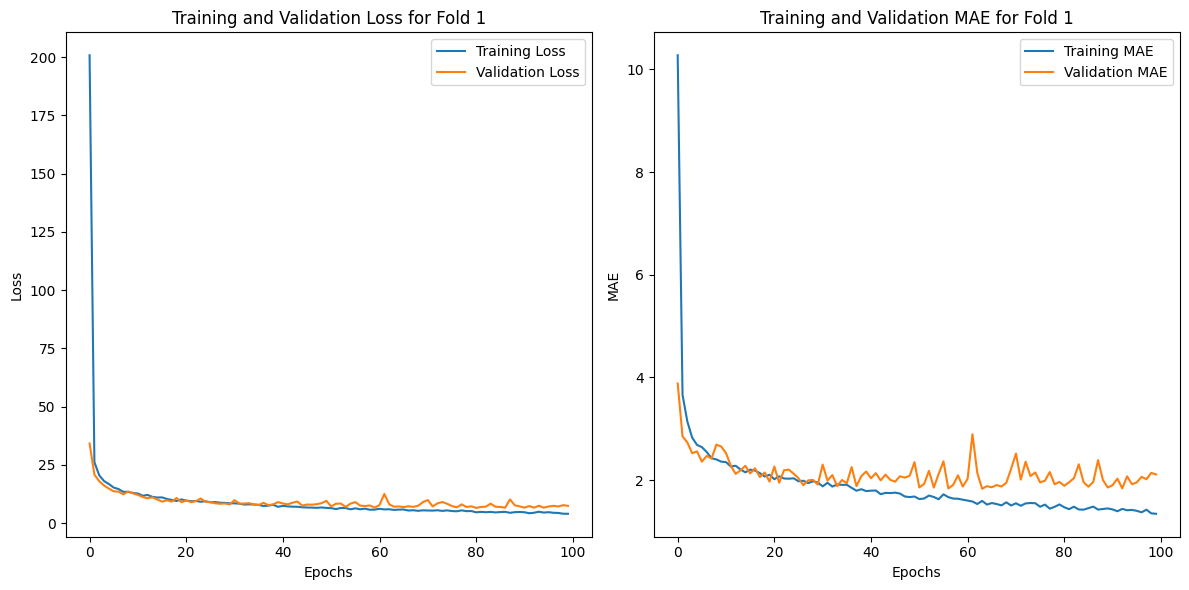

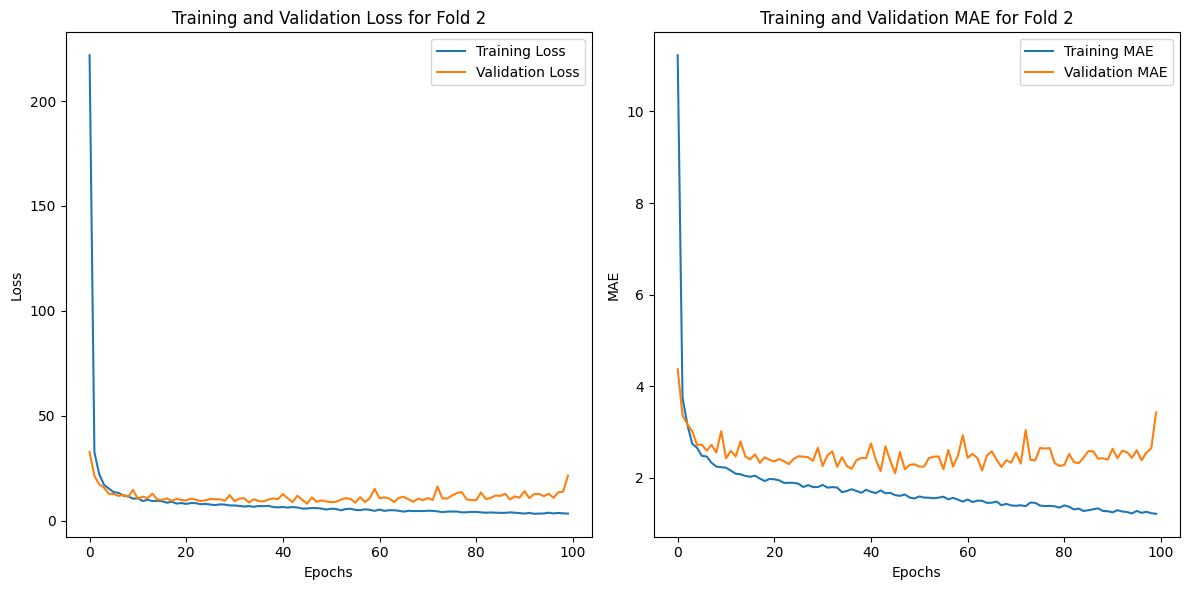

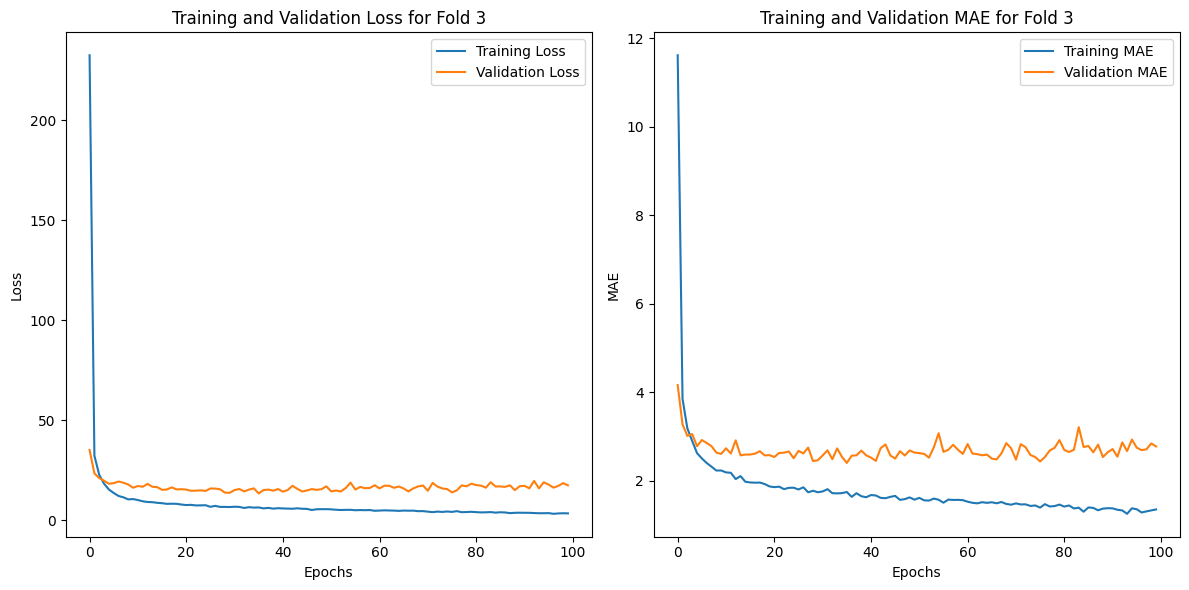

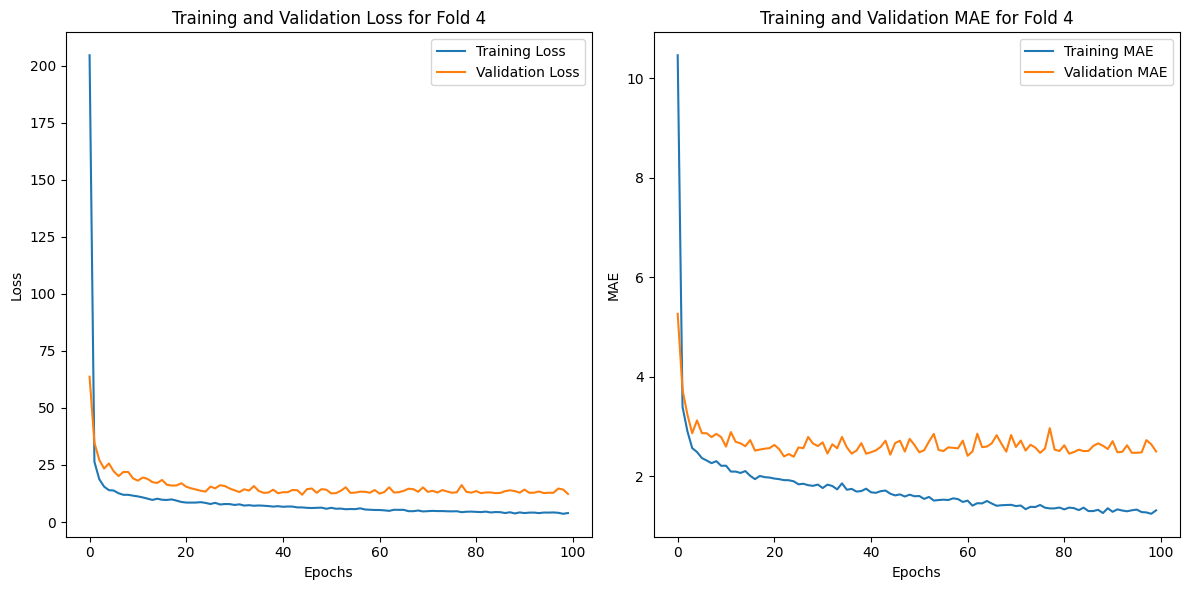

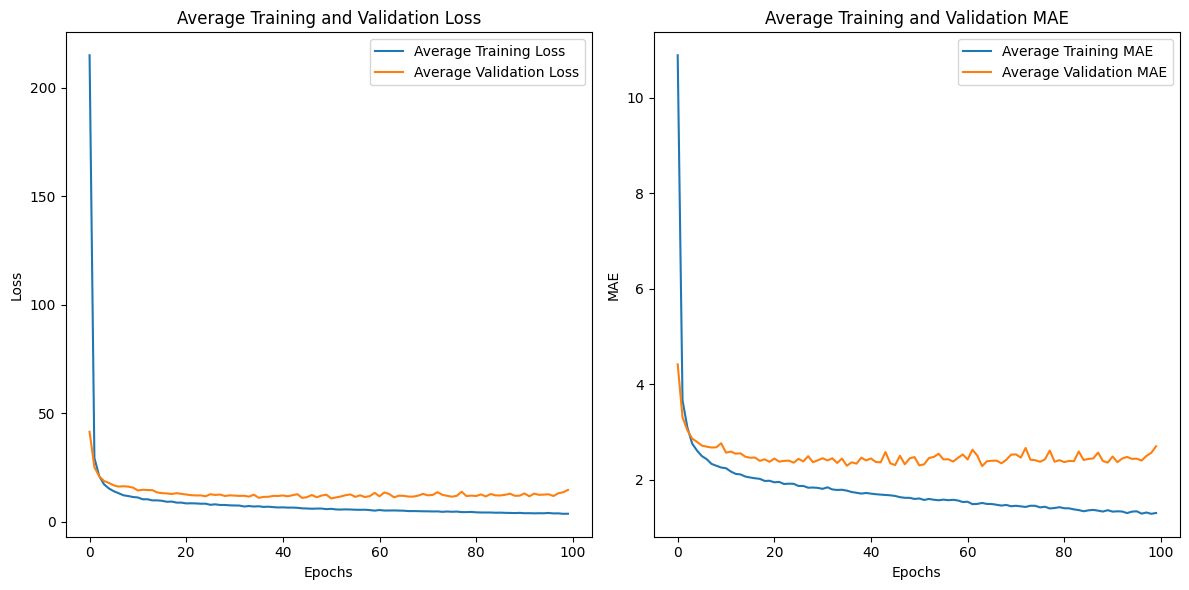

In [ ]:
plot_graphs(all_histories)

Обучение модели на 150 эпохах при K = 4

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 150
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
2.5704286098480225


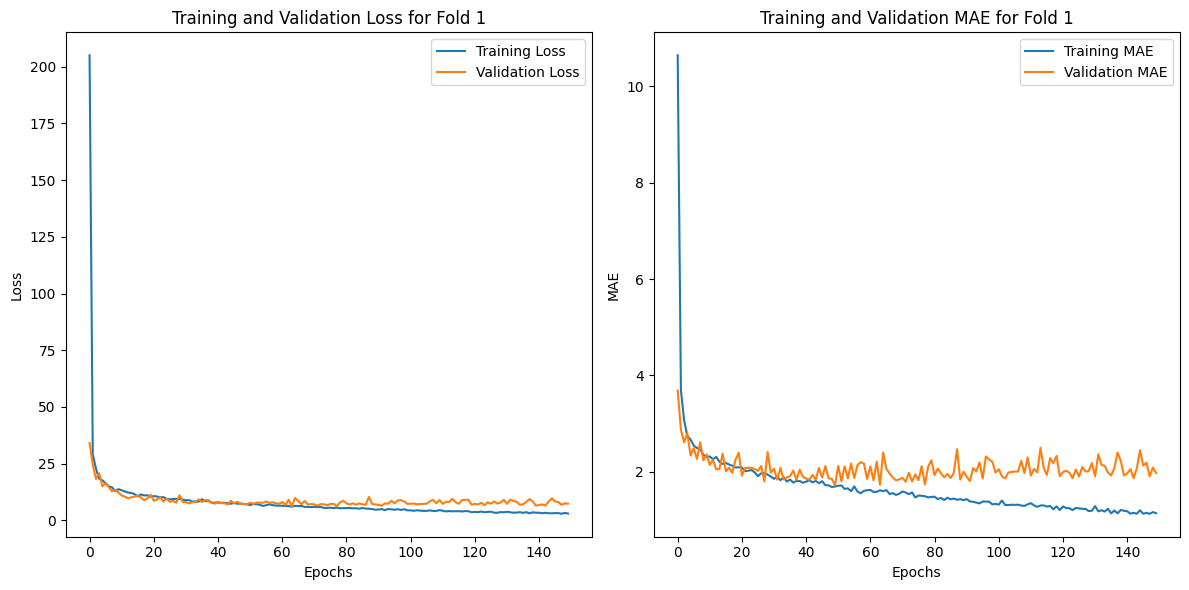

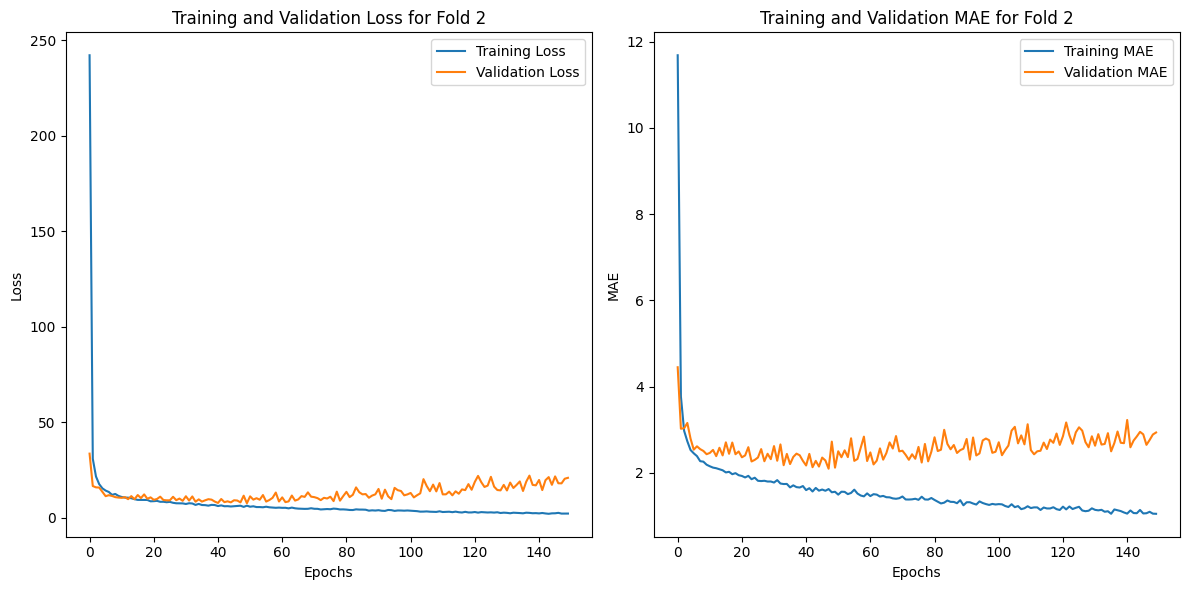

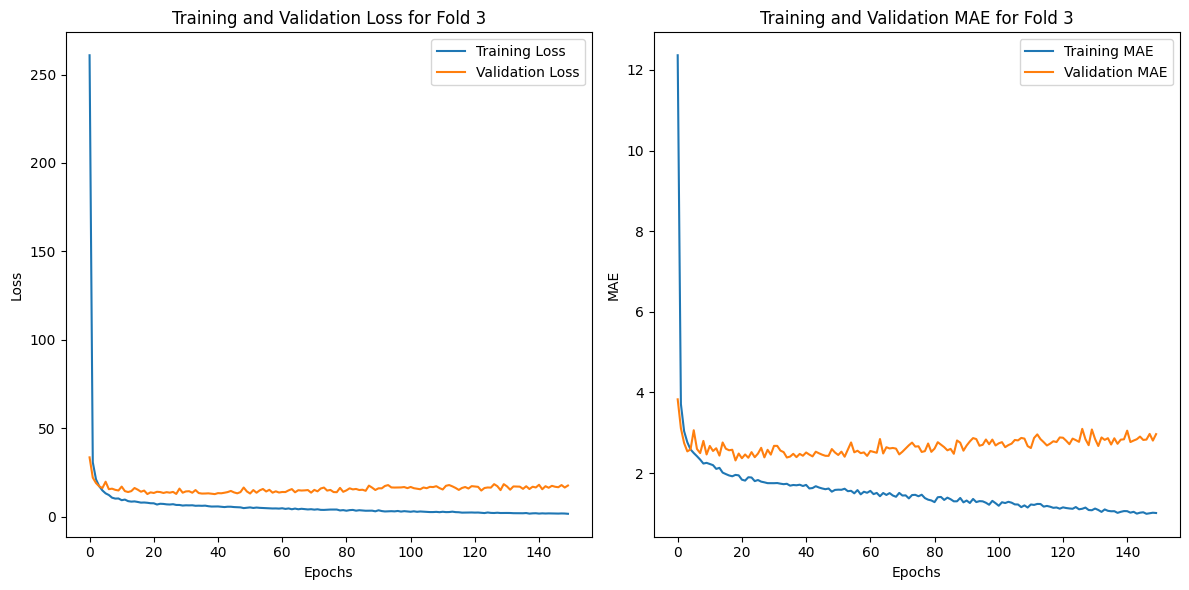

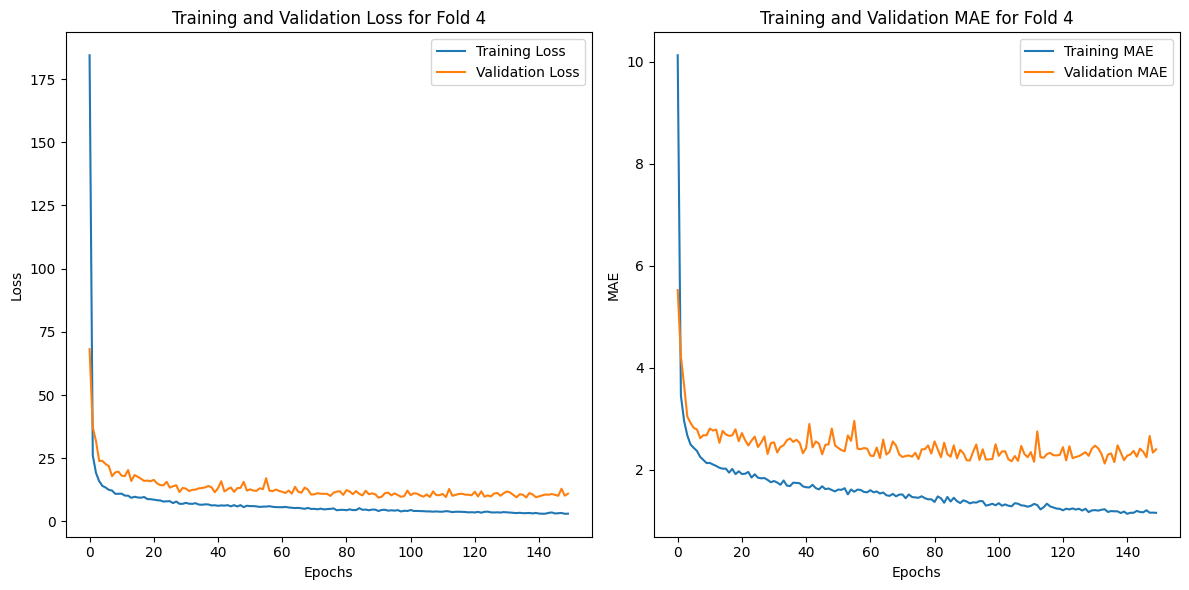

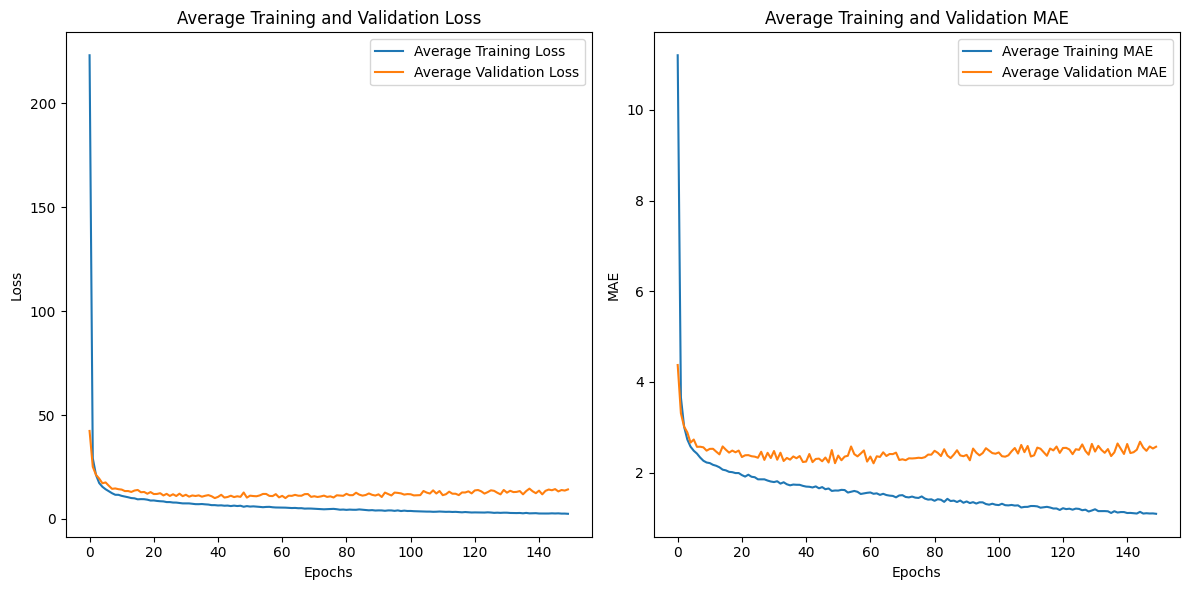

In [ ]:
plot_graphs(all_histories)

Обучение модели на 50 эпохах при K = 4

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 50
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
2.510901391506195


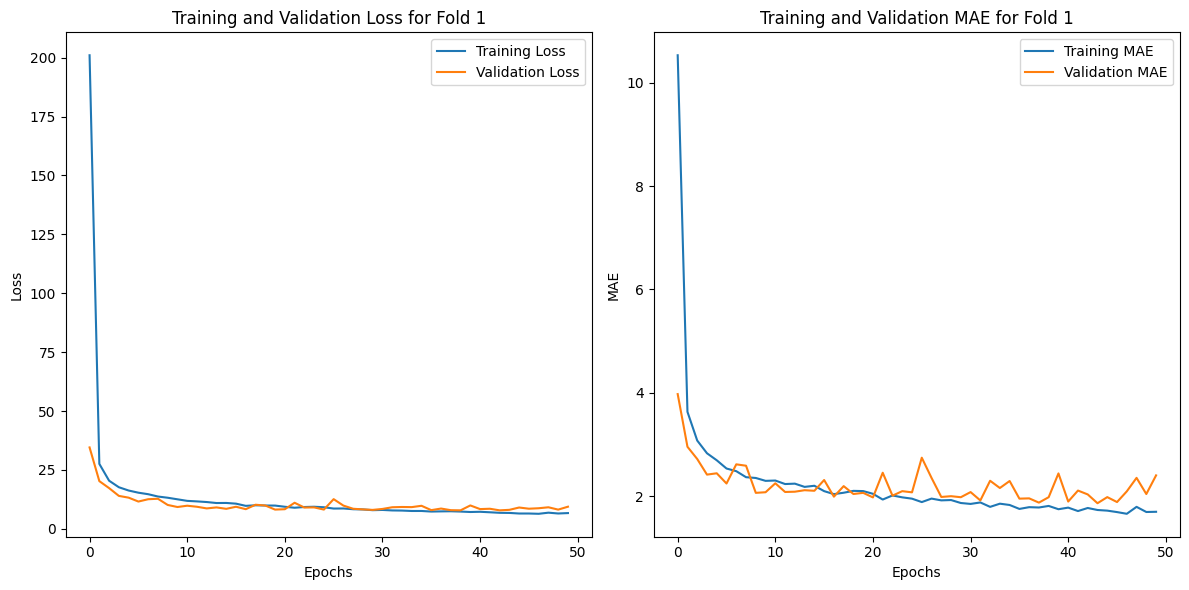

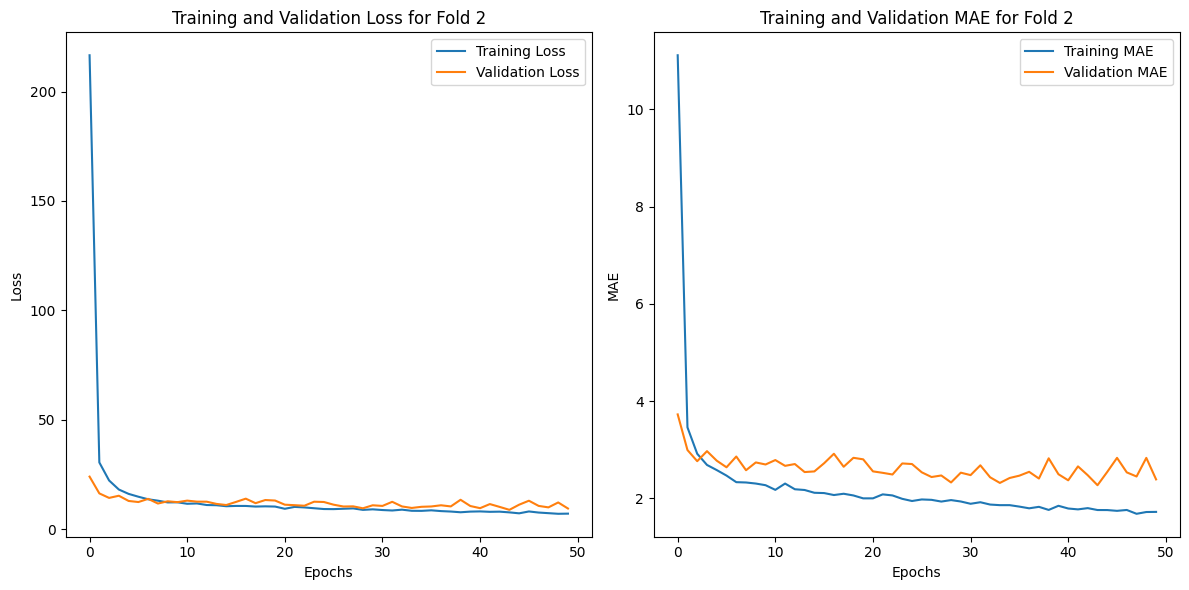

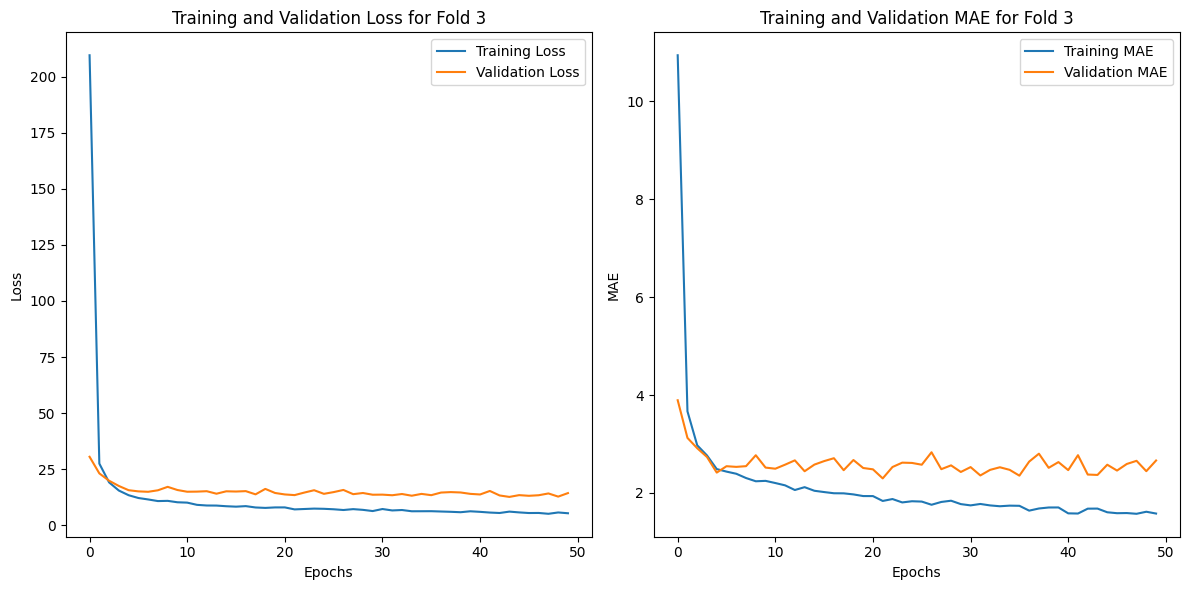

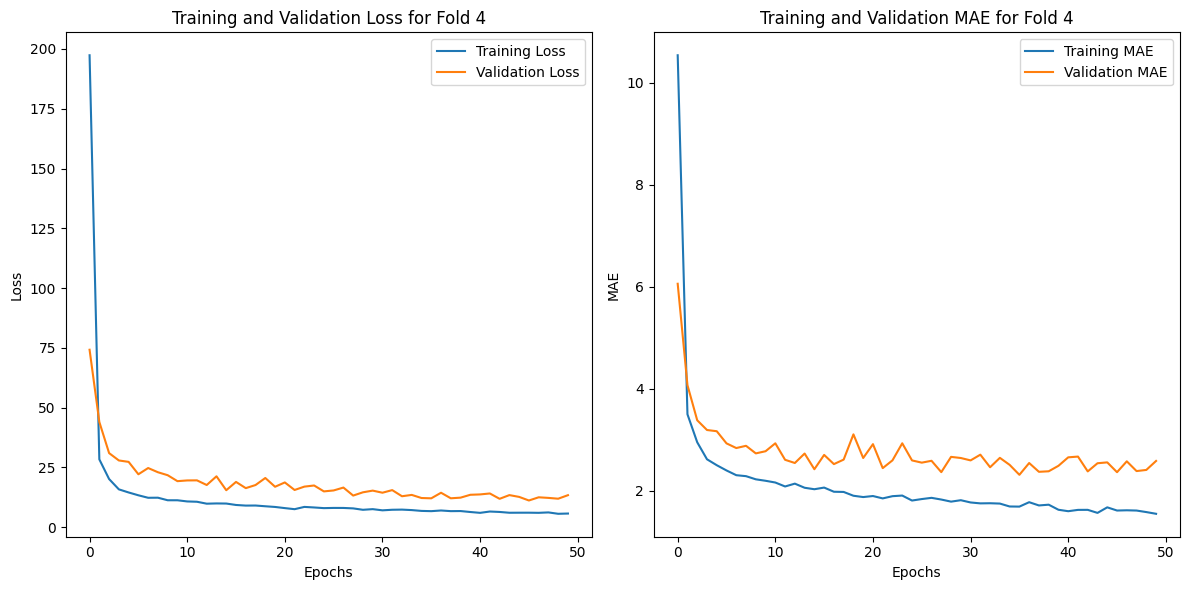

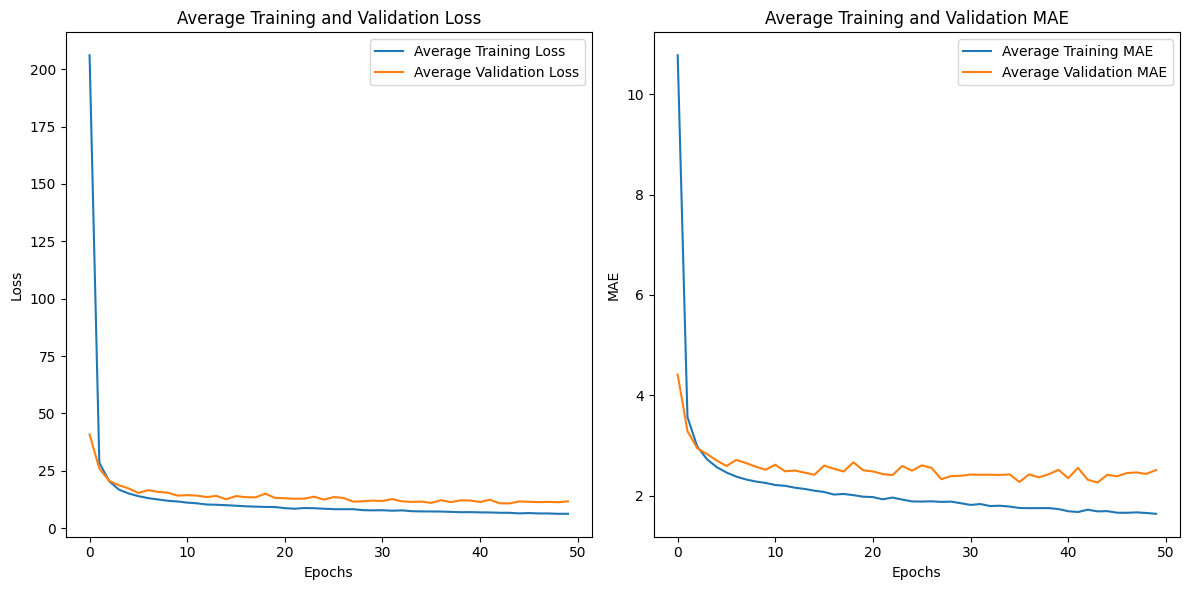

In [ ]:
plot_graphs(all_histories)

Обучение модели на 75 эпохах при K = 5

In [ ]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 75
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
2.3160330772399904


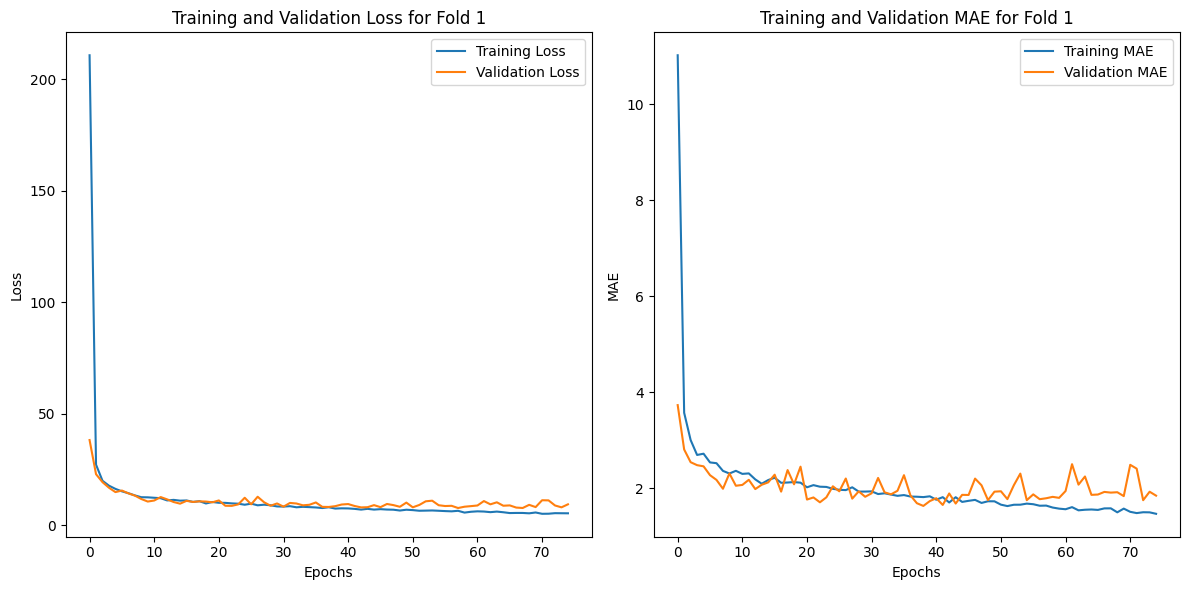

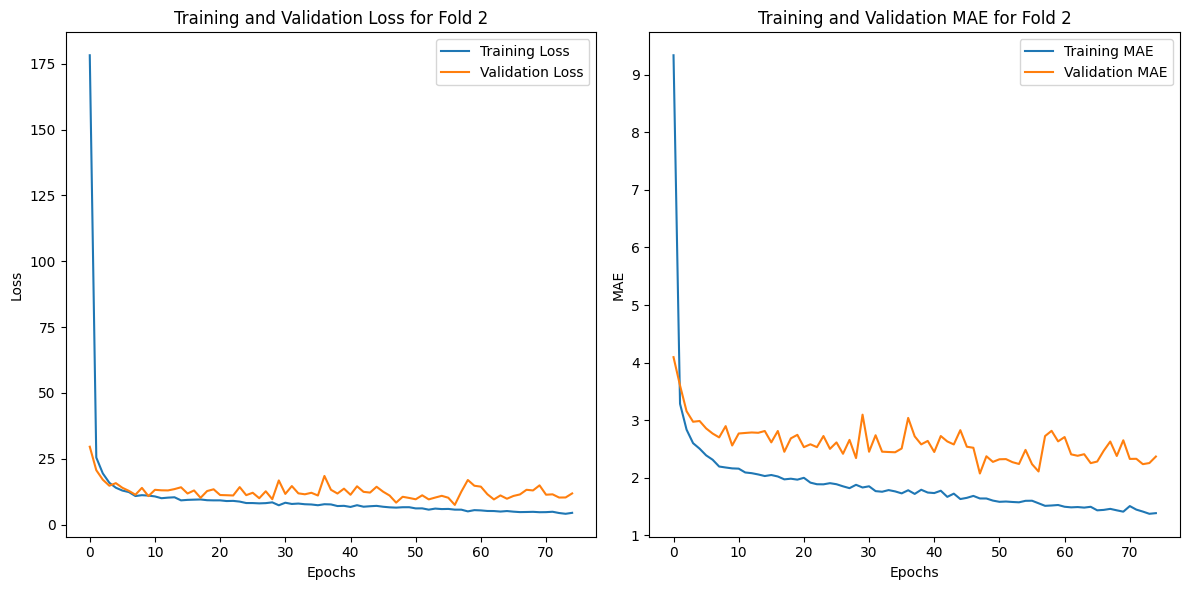

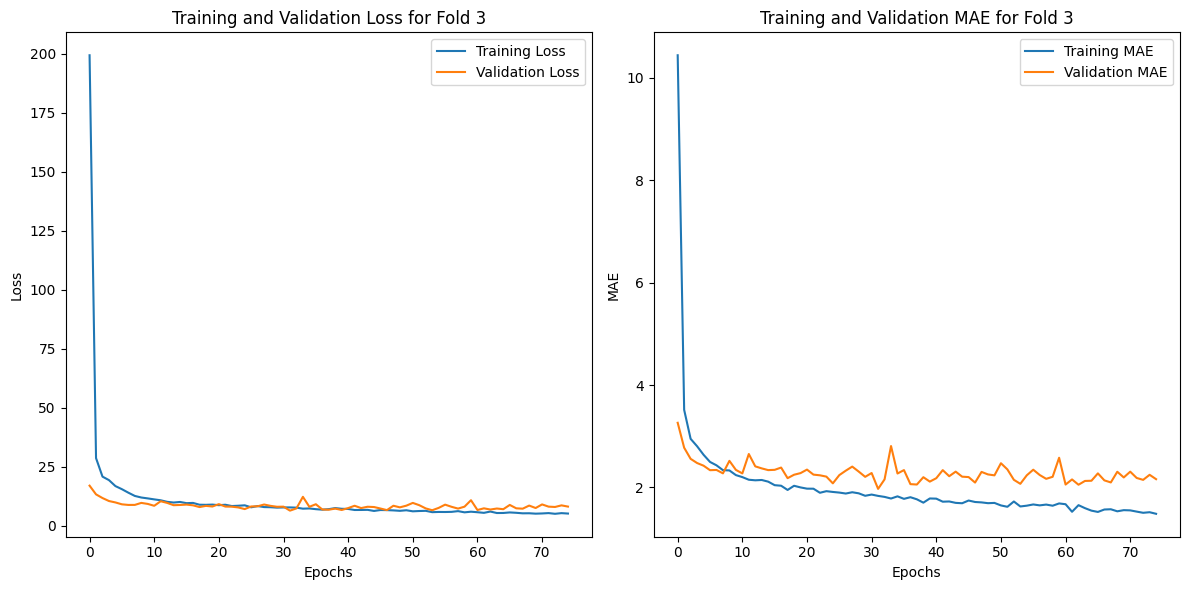

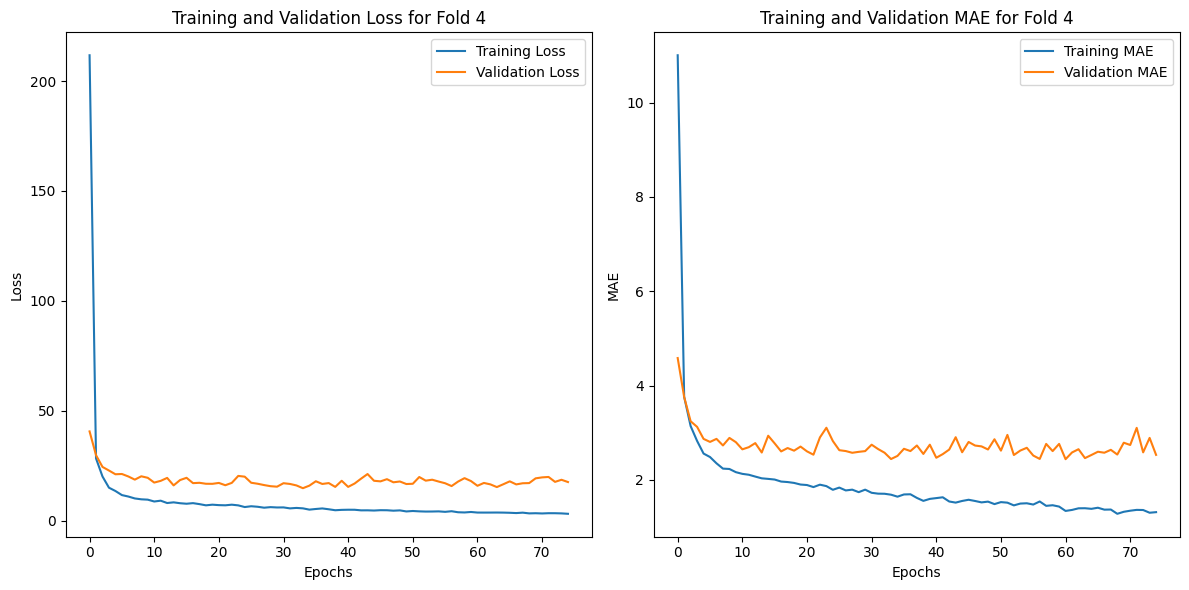

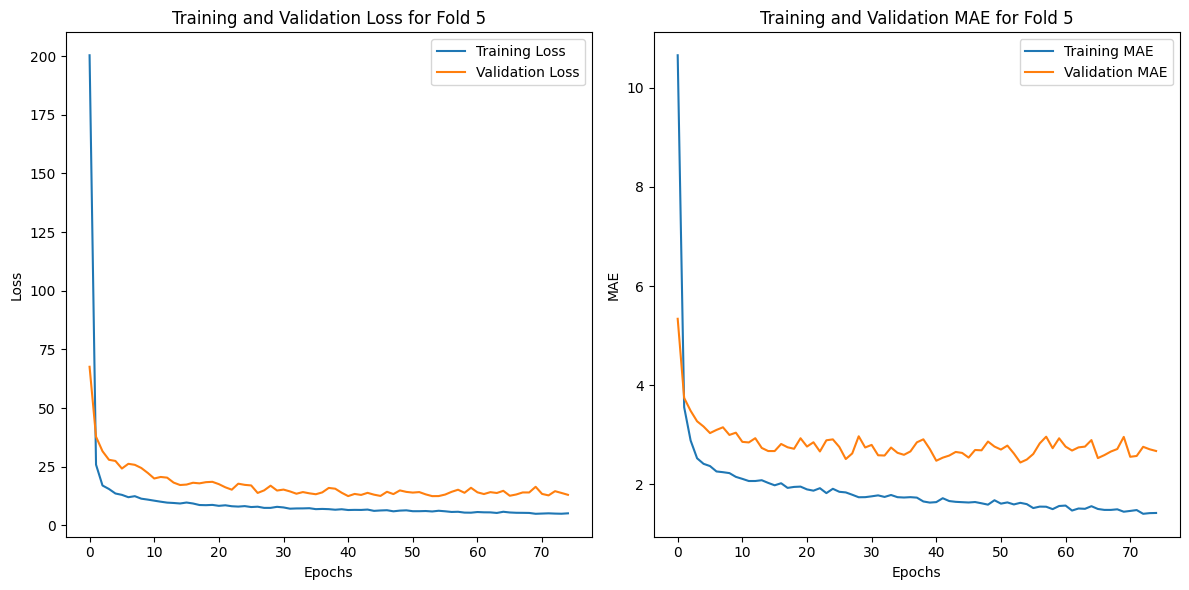

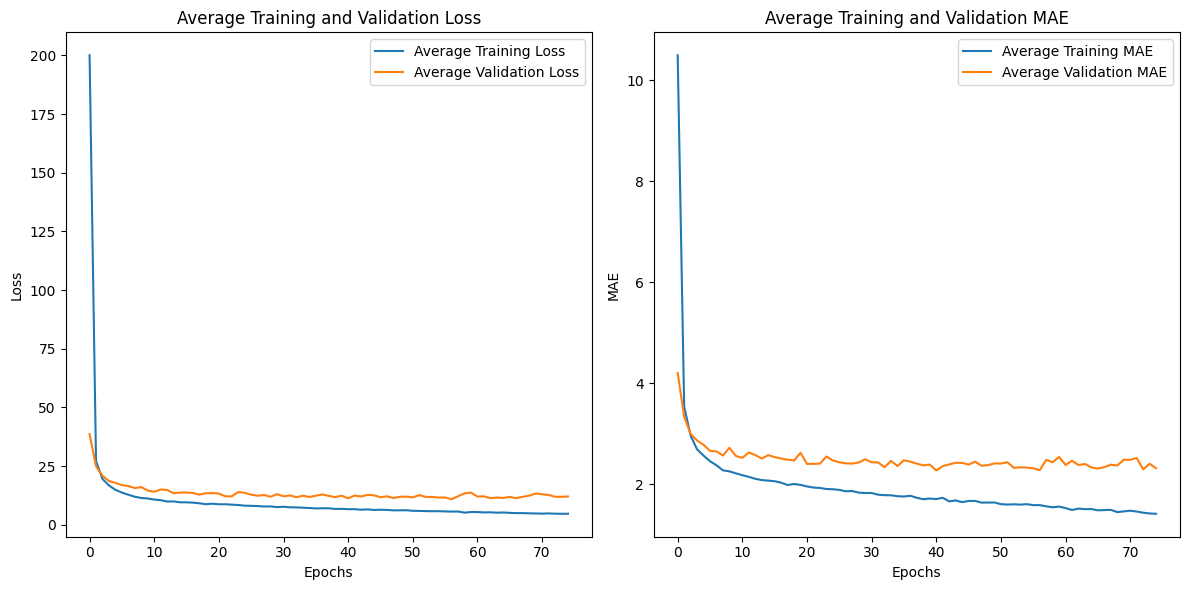

In [ ]:
plot_graphs(all_histories)

Обучение модели на 120 эпохах при K = 5

In [ ]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 120
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
2.449308395385742


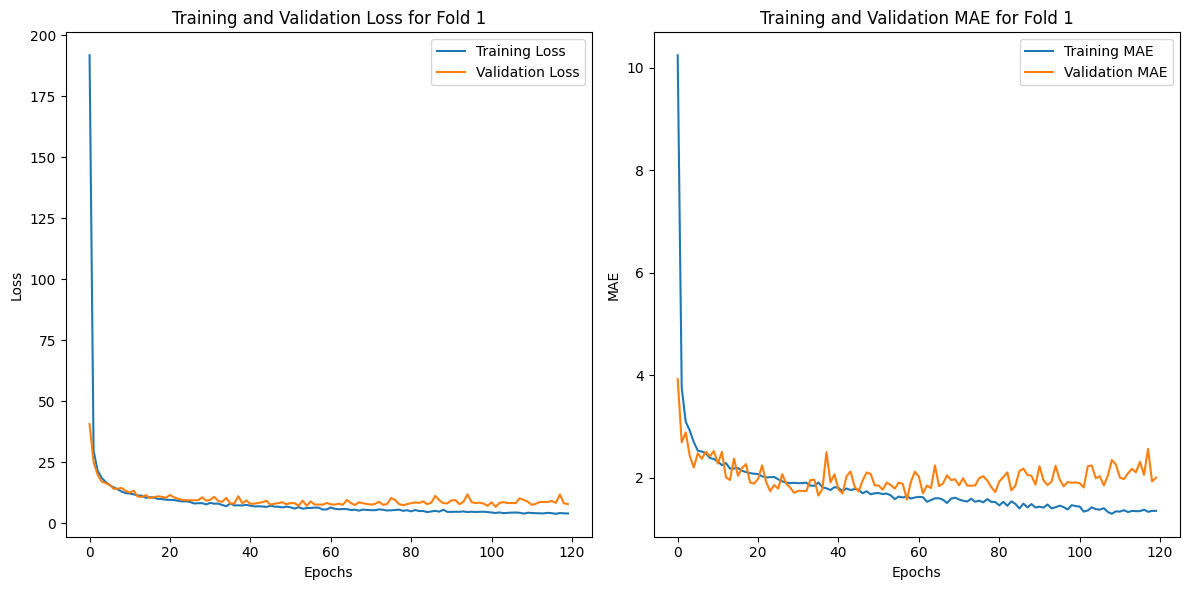

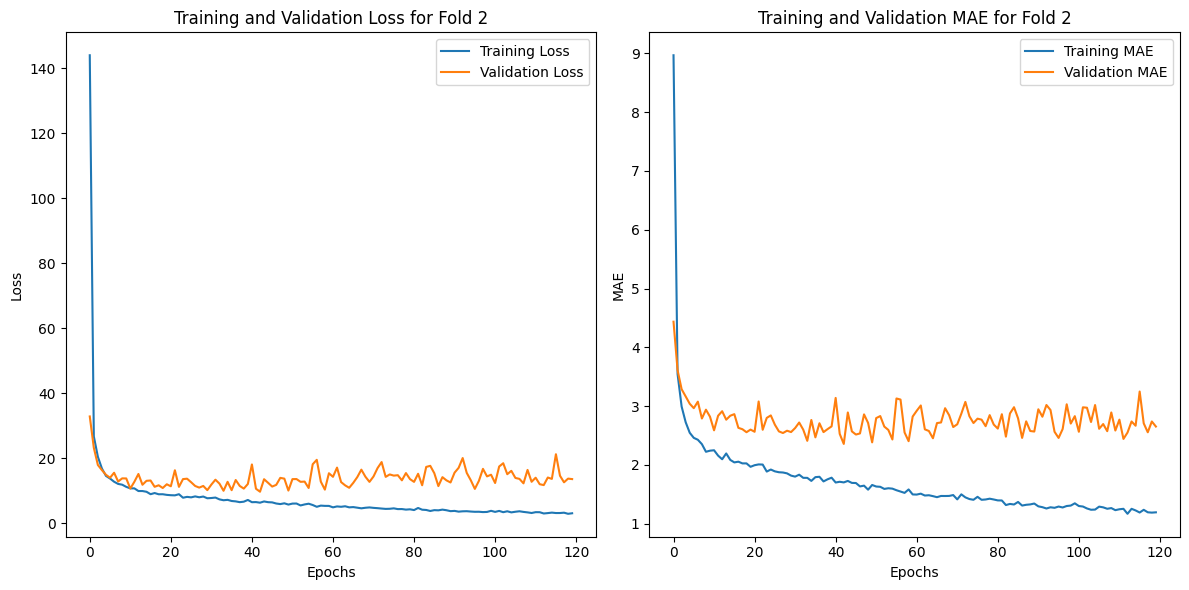

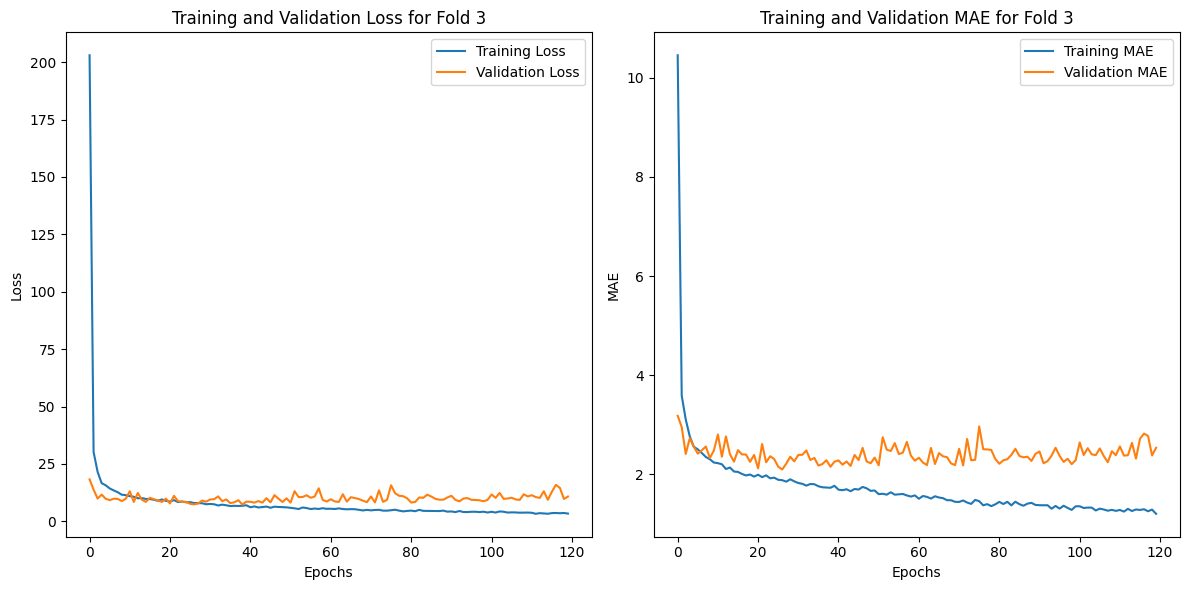

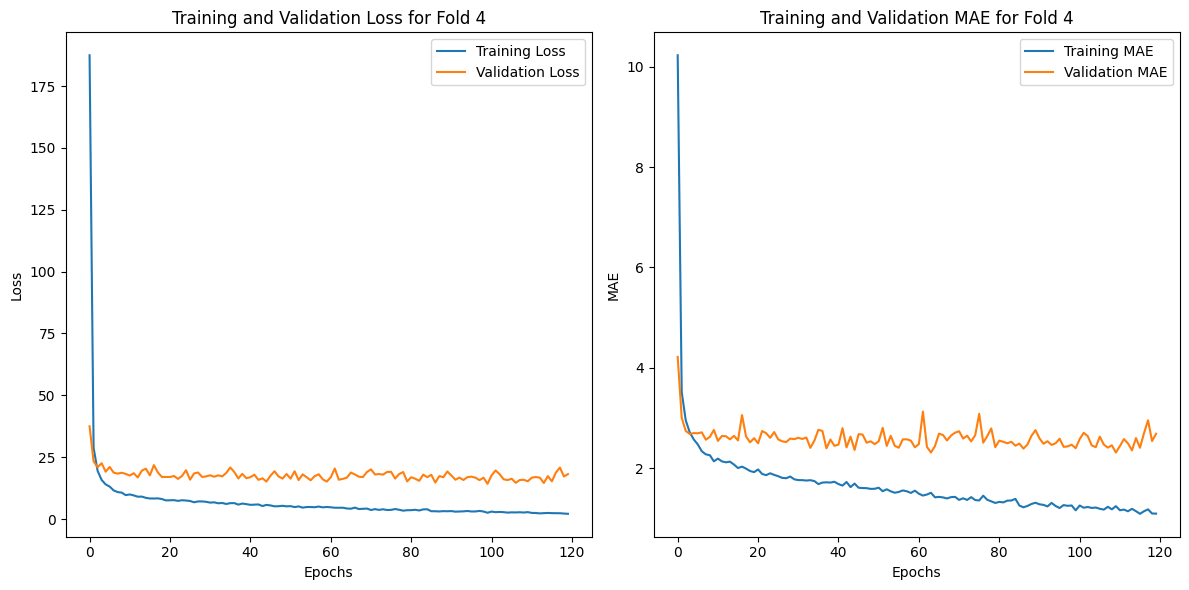

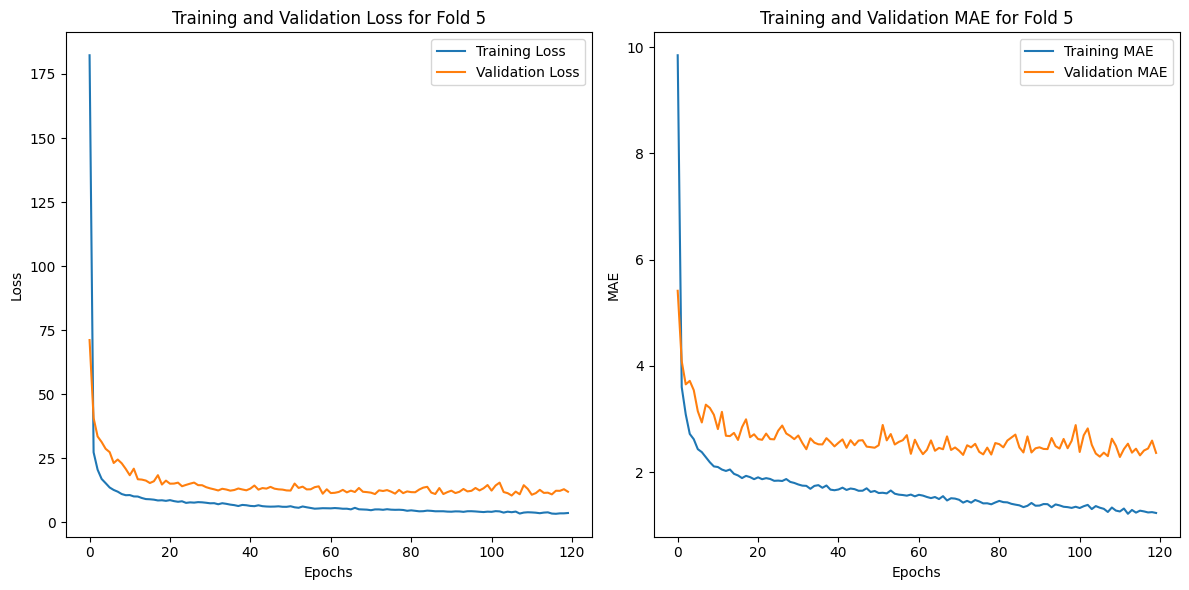

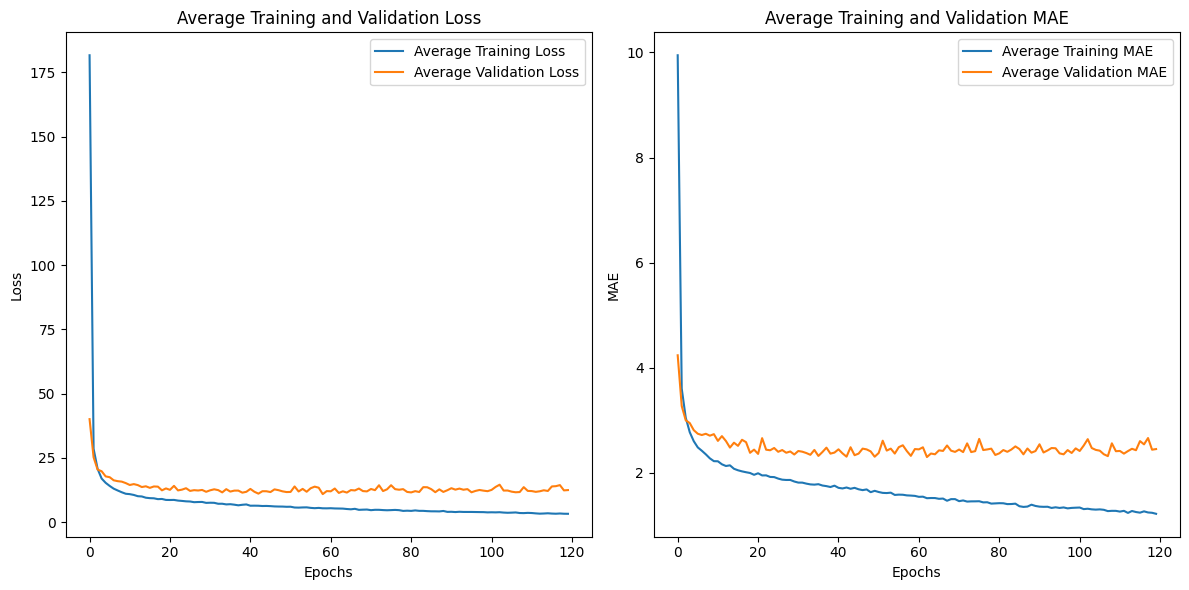

In [ ]:
plot_graphs(all_histories)

Обучение модели на 75 эпохах при K = 3

In [ ]:
k = 3
num_val_samples = len(train_data) // k
num_epochs = 75
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
2.550208648045858


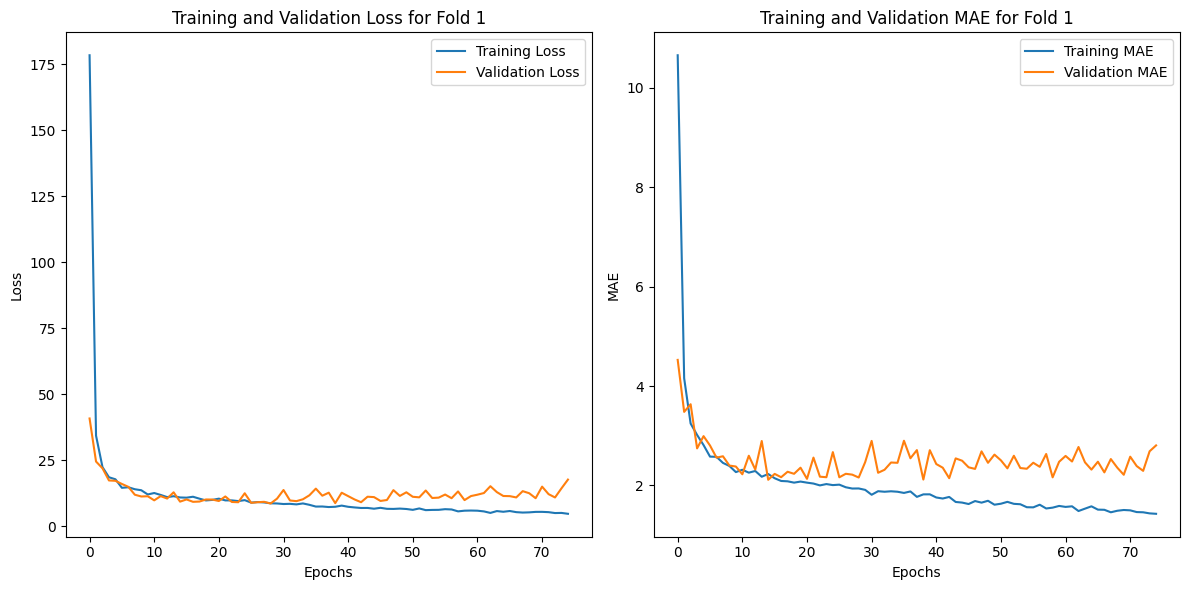

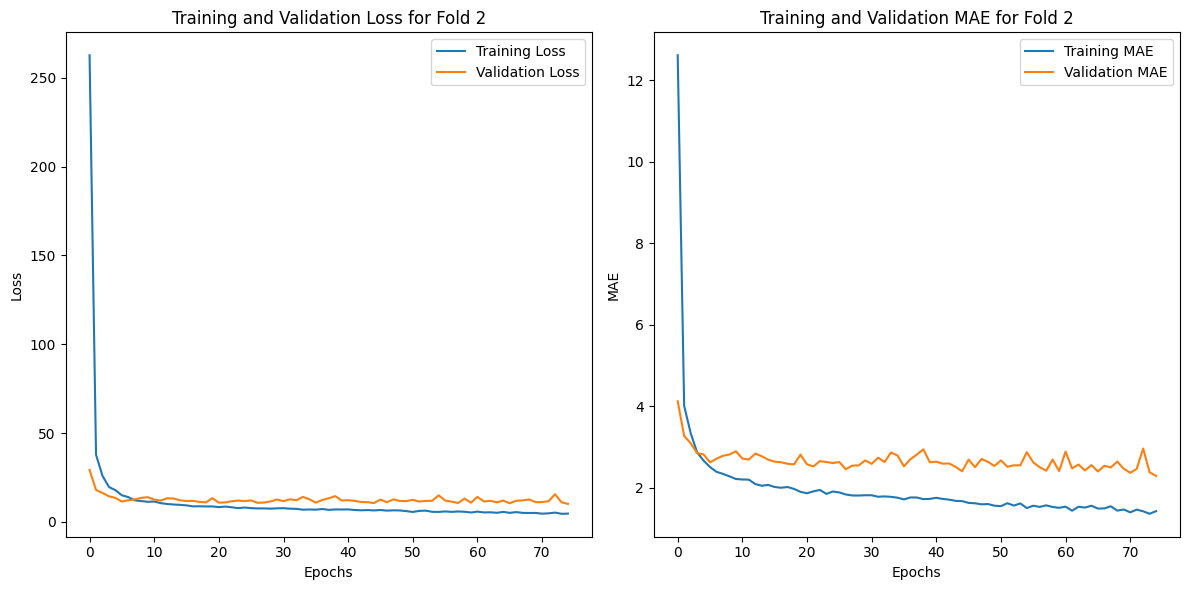

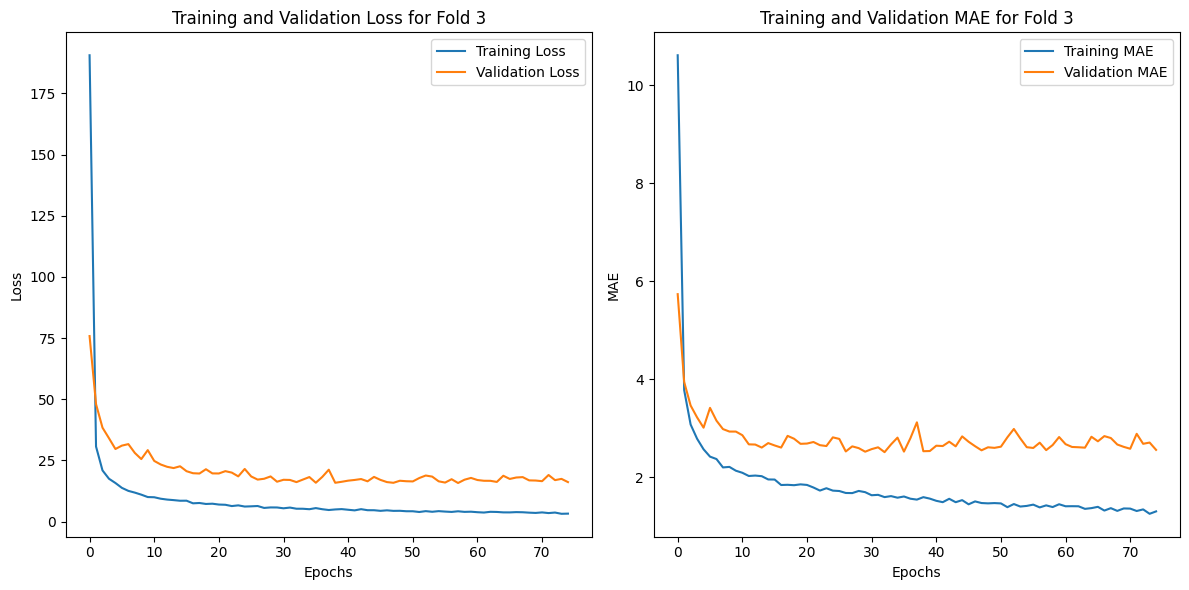

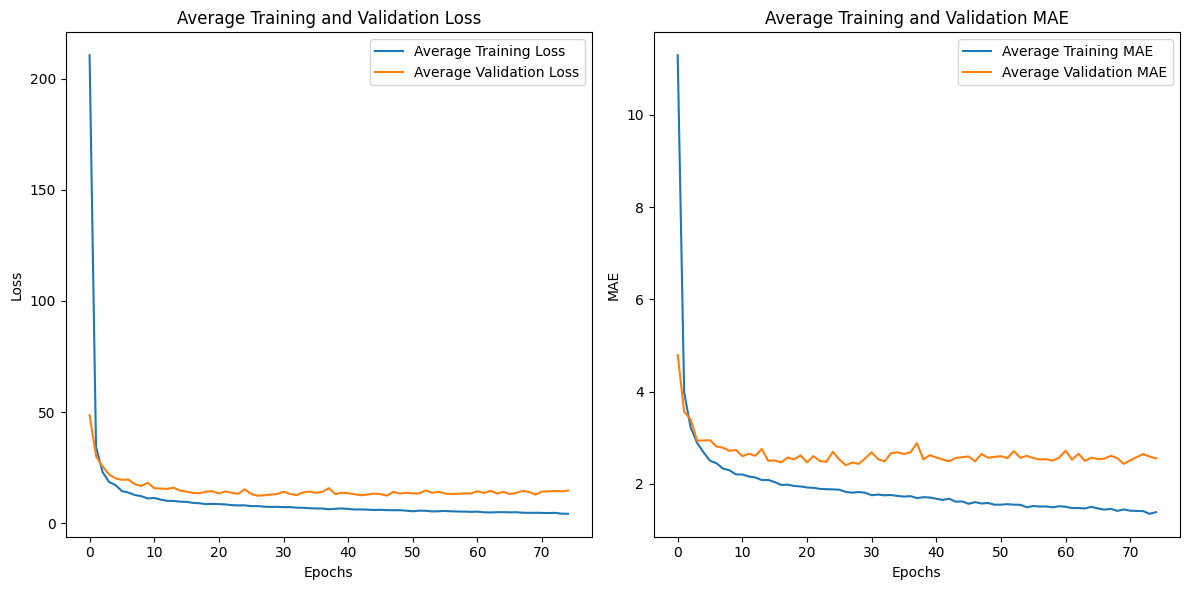

In [ ]:
plot_graphs(all_histories)

Обучение модели на 120 эпохах при K = 3

In [ ]:
k = 3
num_val_samples = len(train_data) // k
num_epochs = 120
all_scores = []
all_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  all_histories.append(history)
print(np.mean(all_scores))

processing fold # 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
2.697178522745768


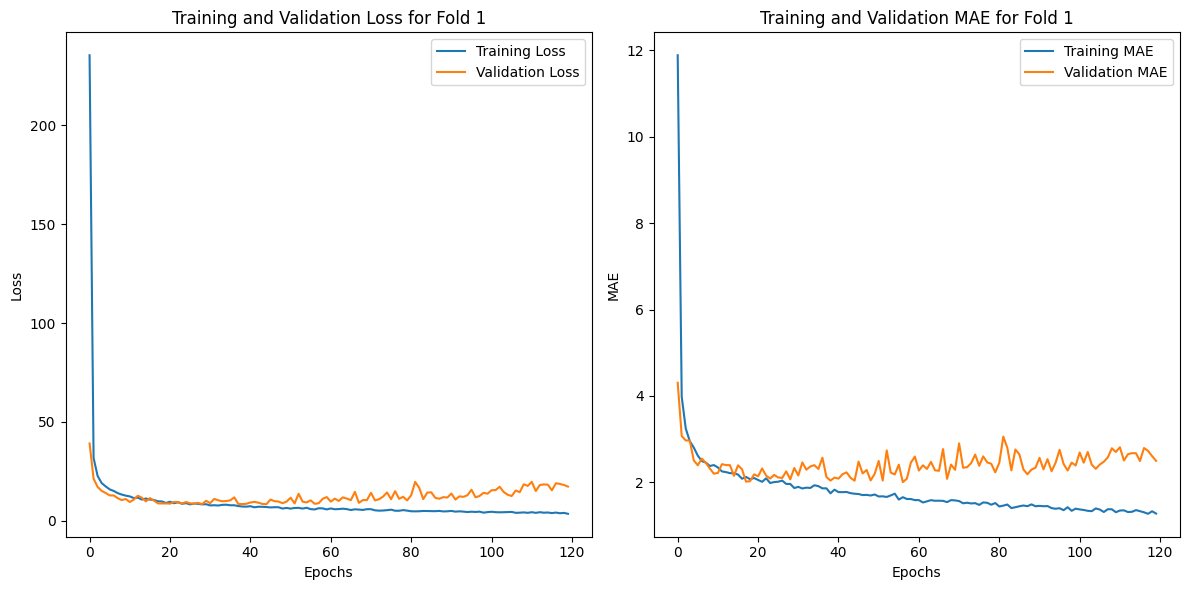

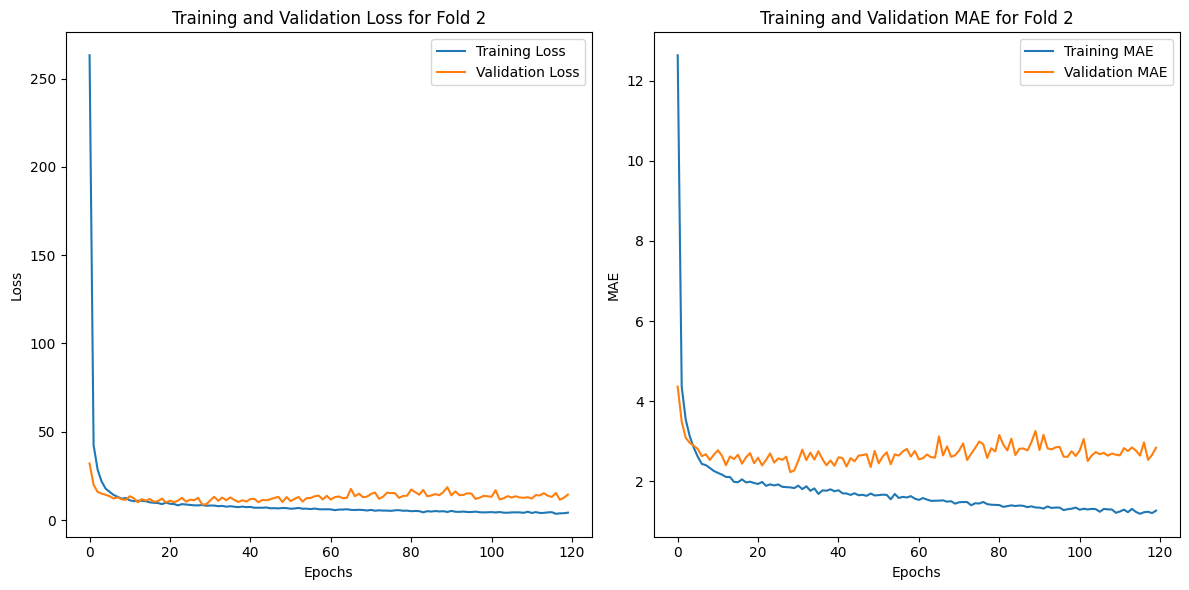

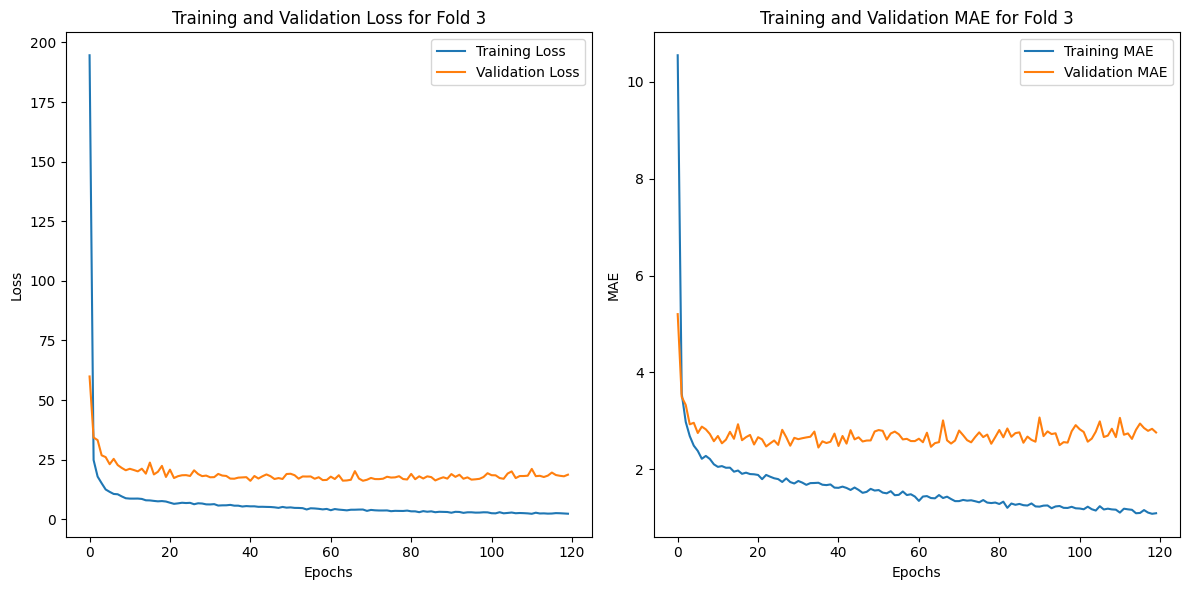

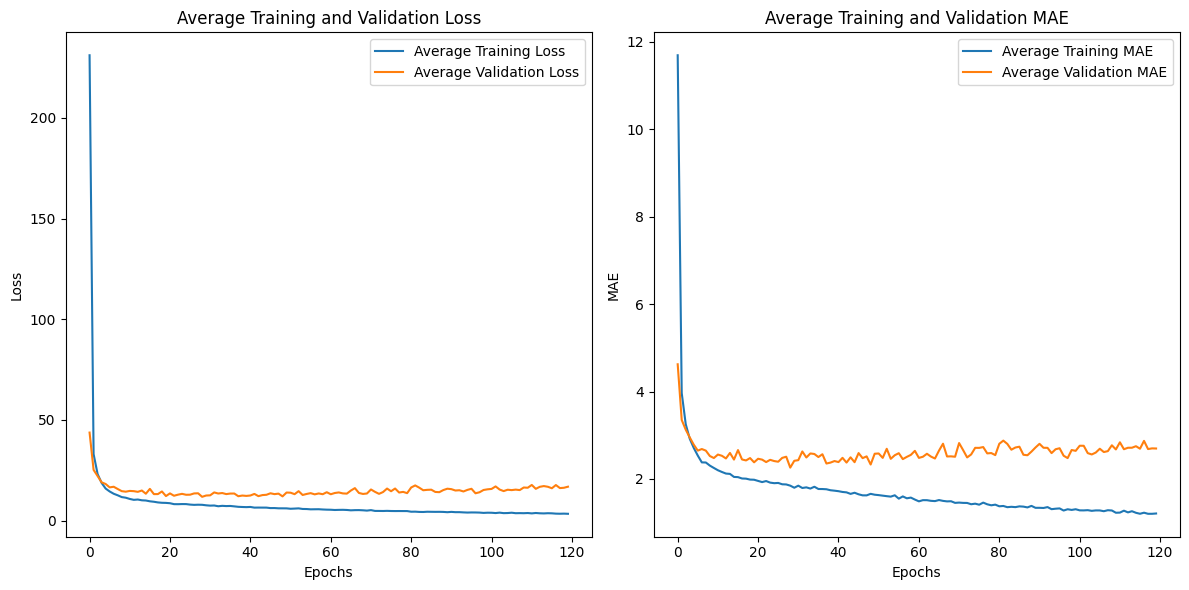

In [ ]:
plot_graphs(all_histories)

### Вывод
В ходе выполнения лабораторной работы были изучены отличия задачи регрессии от задачи классификации, перекрестная проверка. При сравнении полученных сетей можно сделать вывод, что модель, обученная на 75 эпохах, при K = 5, имеет лучшие результаты, ведь MAE в данном случае = 2,316, что соответствует отклонению прогнозов примерно на 2316 $.